### Regression on time series data

#### Bitcoin Price Prediction using ARIMA

In [25]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
from itertools import product
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [26]:
# Load data
df = pd.read_csv('BTC-Daily.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43185.48,49.006289,2.116360e+06
1,1646006400,2022-02-28 00:00:00,BTC/USD,37717.10,44256.08,37468.99,43178.98,3160.618070,1.364723e+08
2,1645920000,2022-02-27 00:00:00,BTC/USD,39146.66,39886.92,37015.74,37712.68,1701.817043,6.418008e+07
3,1645833600,2022-02-26 00:00:00,BTC/USD,39242.64,40330.99,38600.00,39146.66,912.724087,3.573010e+07
4,1645747200,2022-02-25 00:00:00,BTC/USD,38360.93,39727.97,38027.61,39231.64,2202.851827,8.642149e+07


In [27]:
# Splitting the date-time column into separate date and time columns
df[['date', 'time']] = df['date'].apply(lambda x: pd.Series(x.split(' ', 1)))
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.time

df = df.drop('time', axis=1)
df

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01,BTC/USD,43221.71,43626.49,43185.48,43185.48,4.900629e+01,2.116360e+06
1,1646006400,2022-02-28,BTC/USD,37717.10,44256.08,37468.99,43178.98,3.160618e+03,1.364723e+08
2,1645920000,2022-02-27,BTC/USD,39146.66,39886.92,37015.74,37712.68,1.701817e+03,6.418008e+07
3,1645833600,2022-02-26,BTC/USD,39242.64,40330.99,38600.00,39146.66,9.127241e+02,3.573010e+07
4,1645747200,2022-02-25,BTC/USD,38360.93,39727.97,38027.61,39231.64,2.202852e+03,8.642149e+07
...,...,...,...,...,...,...,...,...,...
2646,1417478400,2014-12-02,BTC/USD,378.39,382.86,375.23,379.25,2.593576e+06,6.832530e+03
2647,1417392000,2014-12-01,BTC/USD,376.40,382.31,373.03,378.39,2.520662e+06,6.660560e+03
2648,1417305600,2014-11-30,BTC/USD,376.57,381.99,373.32,373.34,1.145567e+06,3.046330e+03
2649,1417219200,2014-11-29,BTC/USD,376.42,386.60,372.25,376.72,2.746157e+06,7.245190e+03


In [28]:
# Unix-time to 
df.unix = pd.to_datetime(df.unix, unit='s')

# Resampling to daily frequency
df.index = df.unix
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

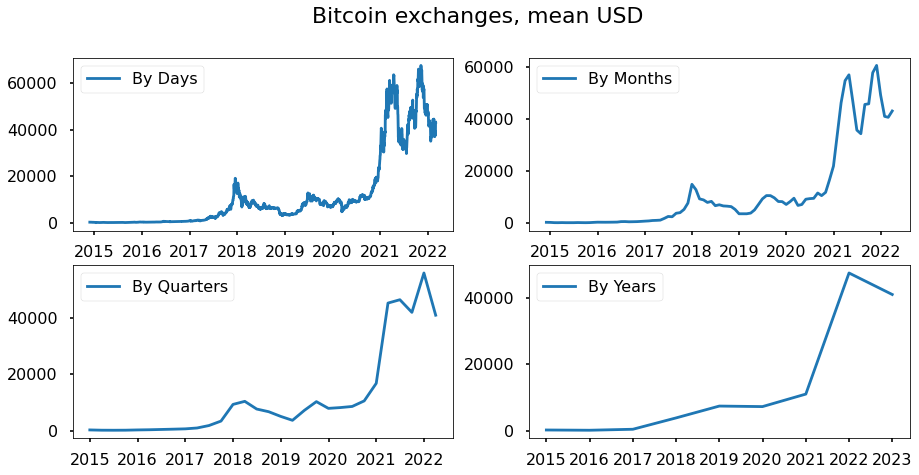

In [29]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.close, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.close, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.close, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.close, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

<Figure size 1080x504 with 0 Axes>

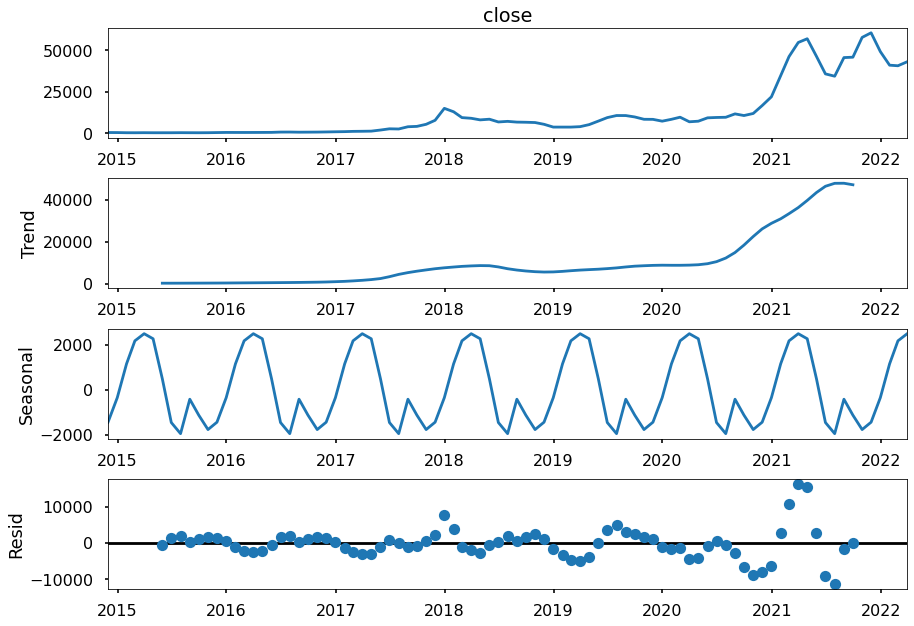

In [30]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.close).plot()
plt.show()

In [31]:
# Box-Cox Transformations
df_month['close_box'], lmbda = stats.boxcox(df_month.close)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.close)[1])

Dickey–Fuller test: p=0.995798


In [32]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.close_box - df_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.111442


Dickey–Fuller test: p=0.000009


<Figure size 1080x504 with 0 Axes>

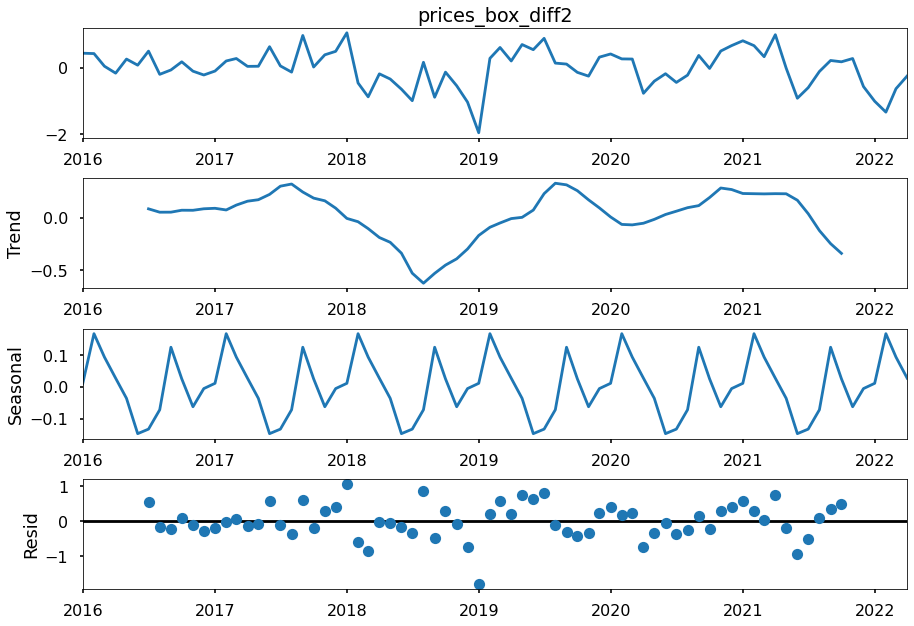

In [33]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

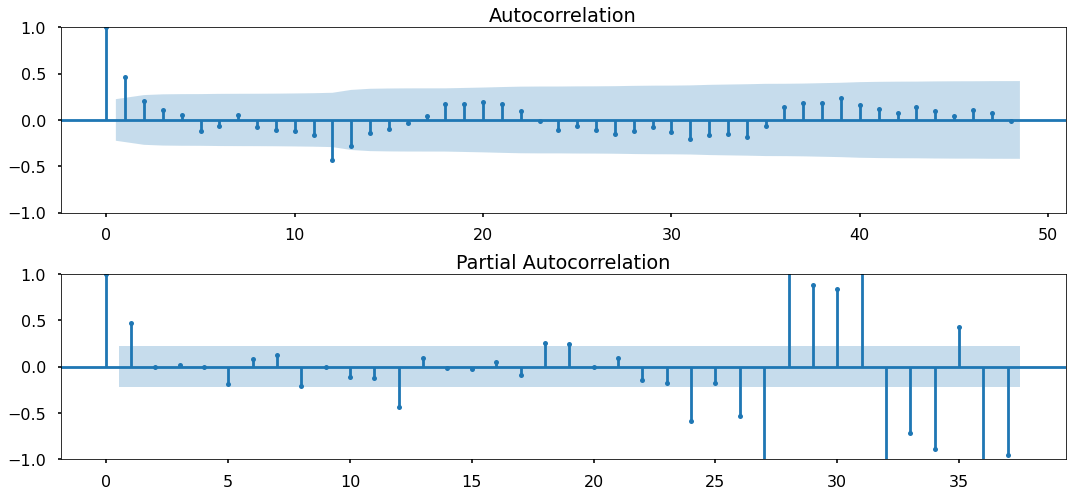

In [34]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df_month.prices_box_diff2[13:].values.squeeze(), lags=37, ax=ax)
plt.tight_layout()
plt.show()

In [35]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.close_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [36]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters        aic
19  (1, 0, 0, 1)  83.848668
7   (0, 1, 0, 1)  84.099630
11  (0, 1, 2, 1)  84.344097
23  (1, 0, 2, 1)  84.631784
25  (1, 1, 0, 1)  85.478801
                                      SARIMAX Results                                       
Dep. Variable:                            close_box   No. Observations:                   89
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 -38.924
Date:                              Fri, 21 Apr 2023   AIC                             83.849
Time:                                      19:41:01   BIC                             90.841
Sample:                                  11-30-2014   HQIC                            86.643
                                       - 03-31-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

Dickey–Fuller test:: p=0.000000


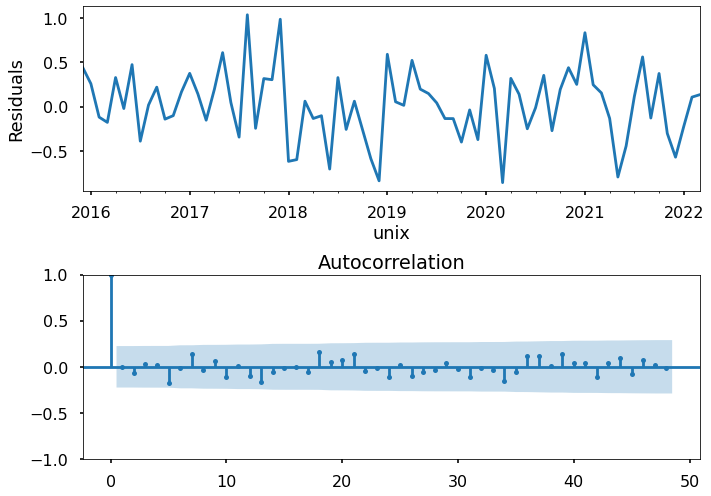

In [37]:
# STL-decomposition
plt.figure(figsize=(10,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

In [38]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

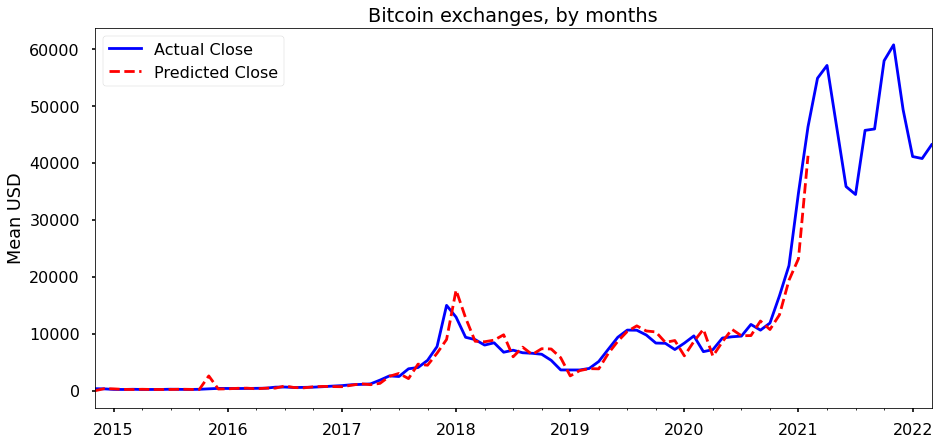

In [39]:
# Prediction
df_month2 = df_month[['close']]
future = pd.DataFrame(columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.close.plot(color='b', label='Actual Close')
df_month2.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('Mean USD')
plt.show()

In [40]:
# Train-test split
train_data = df.iloc[:int(0.8*len(df))]
test_data = df.iloc[int(0.8*len(df)):]

In [41]:
# Fit the SARIMAX model
model = SARIMAX(test_data['close'], order=(2, 1, 4), seasonal_order=(0, 1, 1, 12))
result = model.fit()

In [45]:
# Forecast future prices
future_dates = pd.date_range(start='2022-03-02', end='2023-03-07', freq='D')
future_data = pd.DataFrame({'Date': future_dates})
future_data.set_index('Date', inplace=True)
future_prices = result.forecast(len(future_data))

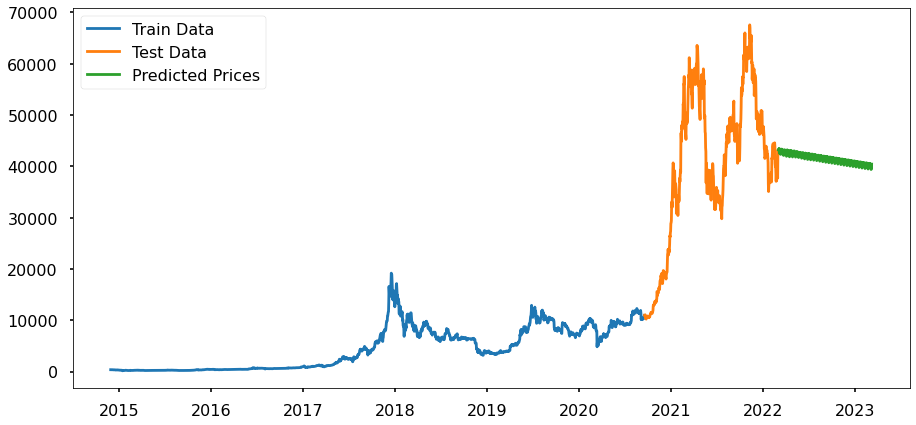

In [47]:
# Plot the results
plt.figure(figsize=(15,7))
plt.plot(train_data['close'], label='Train Data')
plt.plot(test_data['close'], label='Test Data')
plt.plot(future_prices, label='Predicted Prices')
plt.legend()
plt.show()

In [44]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# Predict test data using SARIMAX model
test_data['Predictions'] = result.predict(start=test_data.index[0], end=test_data.index[-1])

# Calculate RMSE
rmse = sqrt(mean_squared_error(test_data['close'], test_data['Predictions']))
print('RMSE:', rmse)

# Calculate R-squared
r2 = r2_score(test_data['close'], test_data['Predictions'])
print('R-squared:', r2)

# Calculate Adjusted R-squared
n = len(test_data)
p = 1  # only 1 feature used (Close)
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print('Adjusted R-squared:', adj_r2)

RMSE: 1813.3217892527884
R-squared: 0.9853004510008021
Adjusted R-squared: 0.9852726635735825
